### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 14 мая 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

In [1]:
import numpy as np

In [4]:
def grad_MSE(y_true, y_pred):
    return - 2 * (y_true - y_pred).astype(float)

In [5]:
def grad_exp(y_true, y_pred):
    return - y_true * np.exp(-y_pred * y_true).astype(float)

In [6]:
def grad_log(y_true, y_pred):
    return - y_true / (1 + np.exp(y_pred * y_true)).astype(float)

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [310]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy

In [357]:
class MyGradientBoostingClassifier:

    def __init__(self, 
                 loss=grad_MSE, 
                 learning_rate=0.1, 
                 n_estimators=10, 
                 colsample=1., 
                 subsample=1., 
                 *args, 
                 **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.lr = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args 
        self.kwargs = kwargs
        self.models = []

    
    def fit(self, X_raw, y, 
            base_model=DecisionTreeRegressor, 
            init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """ 
        self.models = []
        X = deepcopy(X_raw)
        
        n_features = np.ceil((1 - self.colsample) * X.shape[1]).astype(int)
        n_samples = np.ceil((1 - self.subsample) * X.shape[0]).astype(int)
        sample_idx = np.random.choice(X.shape[0], n_samples, replace=False)
        feature_idx = np.random.choice(X.shape[1], n_features, replace=False)
        X[sample_idx, :] = np.NaN
        X[:, feature_idx] = np.NaN

        if init_model is None:
            y_pred = np.zeros_like(y) 
        else:
            self.init_model = init_model()
            self.init_model.fit(X_raw, y)
            y_pred = self.init_model.predict(X_raw)
            
        y_target = y - self.lr * self.loss(y, y_pred) 

        for _ in range(self.n_estimators):
            model = base_model(*self.args, **self.kwargs)
            model.fit(X, y_target)
            y_pred = model.predict(X)
            y_target -= self.lr * self.loss(y, y_pred)
            self.models.append(model)
        
        
        
    def predict(self, X):
        
        y_pred = np.zeros(X.shape[0]) if not hasattr(self, 'init_model') else self.lr * self.init_model.predict(X)

        for model in self.models:
            y_pred += self.lr * model.predict(X)
        
        return y_pred.round(0).astype(int)


In [221]:
my_clf = MyGradientBoostingClassifier(max_depth=2, learning_rate=0.1, n_estimators=10, subsample=0.75, colsample=1.0)
clf = GradientBoostingClassifier(max_depth=2, learning_rate=0.1, n_estimators=10, subsample=0.75)

In [222]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [223]:
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
clf.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=10, subsample=0.75)

In [224]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [264]:
from sklearn.datasets import fetch_california_housing
from tqdm import tqdm
import matplotlib.pyplot as plt 
X, y = fetch_california_housing(return_X_y=True)

In [226]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1489)

In [265]:
n_iters = np.unique(np.logspace(0.4, 3, 50, endpoint=True).astype(int))
scores = []
for n_estimators in tqdm(n_iters):
    my_clf = MyGradientBoostingClassifier(loss=grad_MSE,
                                        max_depth=2, 
                                        learning_rate=0.05, 
                                        n_estimators=n_estimators, 
                                        subsample=0.75, 
                                        colsample=1.0)

    my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)

    val_score = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    scores.append(val_score)

100%|██████████| 46/46 [03:27<00:00,  4.50s/it]


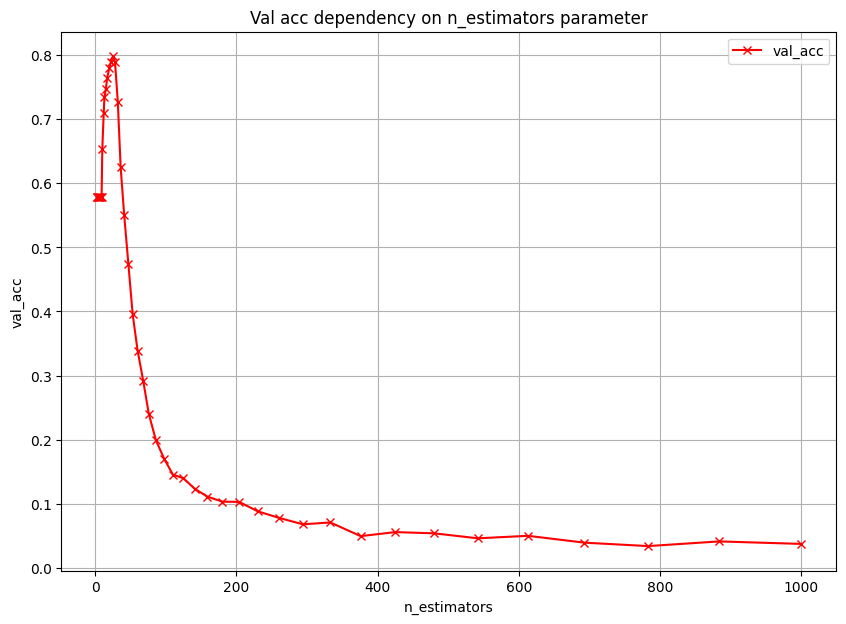

In [278]:
plt.figure(figsize=(10,7))
plt.plot(n_iters, scores, '-x', color='r', label='val_acc')
plt.grid()
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("val_acc")
plt.title("Val acc dependency on n_estimators parameter")
plt.show()

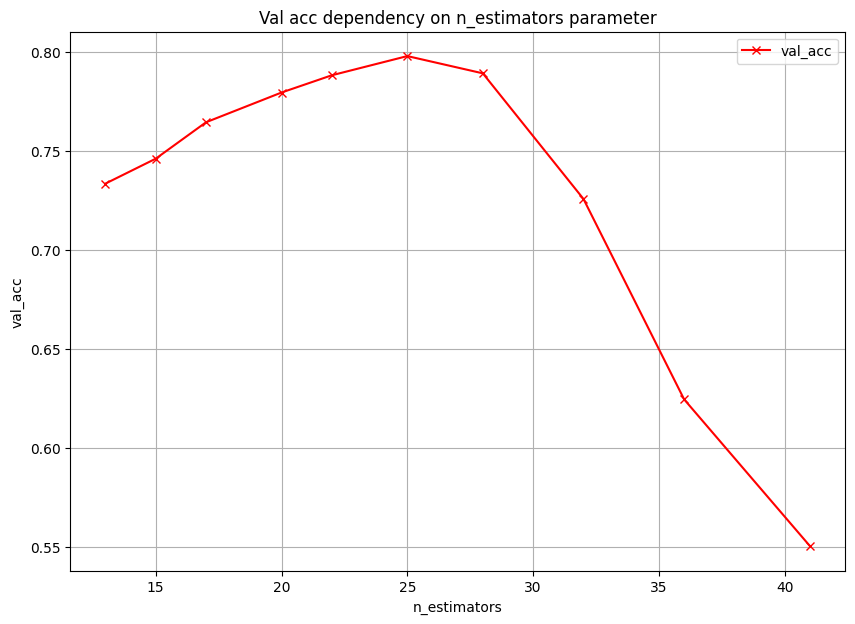

In [281]:
max_arg = np.argmax(scores)
plt.figure(figsize=(10,7))
plt.plot(n_iters[max_arg - 5: max_arg + 5], scores[max_arg - 5: max_arg + 5], '-x', color='r', label='val_acc')
plt.grid()
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("val_acc")
plt.title("Val acc dependency on n_estimators parameter")
plt.show()

In [368]:
my_clf = MyGradientBoostingClassifier(loss=grad_MSE,
                                        max_depth=6, 
                                        learning_rate=0.05, 
                                        n_estimators=25, 
                                        subsample=1.0, 
                                        colsample=1.0)
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)

accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8648255813953488

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [315]:
from sklearn.ensemble import RandomForestRegressor

### 1 

In [345]:
my_clf = MyGradientBoostingClassifier(loss=grad_MSE,
                                        max_depth=10, 
                                        learning_rate=0.1, 
                                        n_estimators=10, 
                                        subsample=1.0, 
                                        colsample=1.0)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)

accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8866279069767442

### 2 

In [327]:
N = 10
boosting_models = []

for _ in tqdm(range(N)):
    
    idxs = np.random.choice(X_train.shape[0], X_train.shape[0])
    X_bt = X_train[idxs, :]
    y_bt = y_train[idxs]
    
    my_clf = MyGradientBoostingClassifier(loss=grad_MSE,
                                        max_depth=10, 
                                        learning_rate=0.1, 
                                        n_estimators=10, 
                                        subsample=1.0, 
                                        colsample=1.0)
    my_clf.fit(X_bt, y_bt, base_model=RandomForestRegressor)
    boosting_models.append(my_clf)
        

100%|██████████| 10/10 [12:01<00:00, 72.18s/it]


In [335]:
preds_bagg = None
for model in tqdm(boosting_models):
    y_pred = my_clf.predict(X_test)
    preds_bagg = y_pred if preds_bagg is None else np.vstack([preds_bagg, y_pred])
final_pred = preds_bagg.mean(axis=0)
final_score = accuracy_score(y_pred=final_pred, y_true=y_test)
print(final_score)

100%|██████████| 10/10 [00:01<00:00,  5.05it/s]

0.873546511627907


Бэггинг помогает снизить variance, бустинг пытается уменьшить bias. В общем и целом результат улучшается, но незначительно, в основном эти два подхода друг друга балансируют, но синергии не происходит

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [362]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [364]:
my_clf = MyGradientBoostingClassifier(loss=grad_MSE,
                                        max_depth=6, 
                                        learning_rate=0.1, 
                                        n_estimators=10, 
                                        subsample=1.0, 
                                        colsample=1.0)

my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor, init_model=None)
print(f"No init_model: {accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test):.3f}")
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor, init_model=SVR)
print(f"SVR: {accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test):.3f}")
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor, init_model=LinearRegression)
print(f"LinearRegression: {accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test):.3f}")
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor, init_model=RandomForestRegressor)
print(f"RandomForestRegressor: {accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test):.3f}")

No init_model: 0.858
SVR: 0.863
LinearRegression: 0.856
RandomForestRegressor: 0.865


Скорость сходимости должна вырасти, если первый предикт будет осознанным, но в итоге бустинг сойдётся примерно к тому же качеству

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

